In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import shap

os.chdir('/Users/stevengeorge/Documents/Github/fpl-analysis/')

from src.models.utils import _load_model_from_pickle

/anaconda3/envs/fpl_analysis/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
new_lgbm = _load_model_from_pickle('src/models/pickles/v2_2_lgbm_point_predictor.pickle')
new_lgbm

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.03837156769109096,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=275, n_jobs=-1, num_leaves=200,
              objective=None, random_state=None, reg_alpha=0.01138730799801102,
              reg_lambda=0.9537776429751255, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

## Evaluate on training set

In [9]:
training_data = pd.read_parquet('src/models/train_test_data/v_2_2_lgbm_training_data.parquet')
print(training_data.shape)
training_data.head()

(56091, 294)


,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,...,own_goals_EMA,own_goals_L1,own_goals_L2,own_goals_L3,own_goals_L4,own_goals_D1,own_goals_D2,own_goals_D3,own_goals_D4,total_points_plus_1_gw
0,0,0,0,0,0.0,0,0,0.0,0.0,0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,0,0,0,0,0.0,0,0,0.0,0.0,0,...,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0
2,0,0,0,0,0.0,0,0,0.0,0.0,0,...,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0
3,0,0,0,0,0.0,0,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0
4,0,0,0,0,0.0,0,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
object_columns = list(training_data.select_dtypes('object').columns)
object_columns

['name', 'team_name', 'season', 'team_name_opponent']

In [5]:
training_predictions = new_lgbm.predict(
    training_data.drop(
        object_columns + ['total_points_plus_1_gw'],
        axis=1
    )
)

In [6]:
mean_squared_error(training_data['total_points_plus_1_gw'], training_predictions)

1.1866161071810595

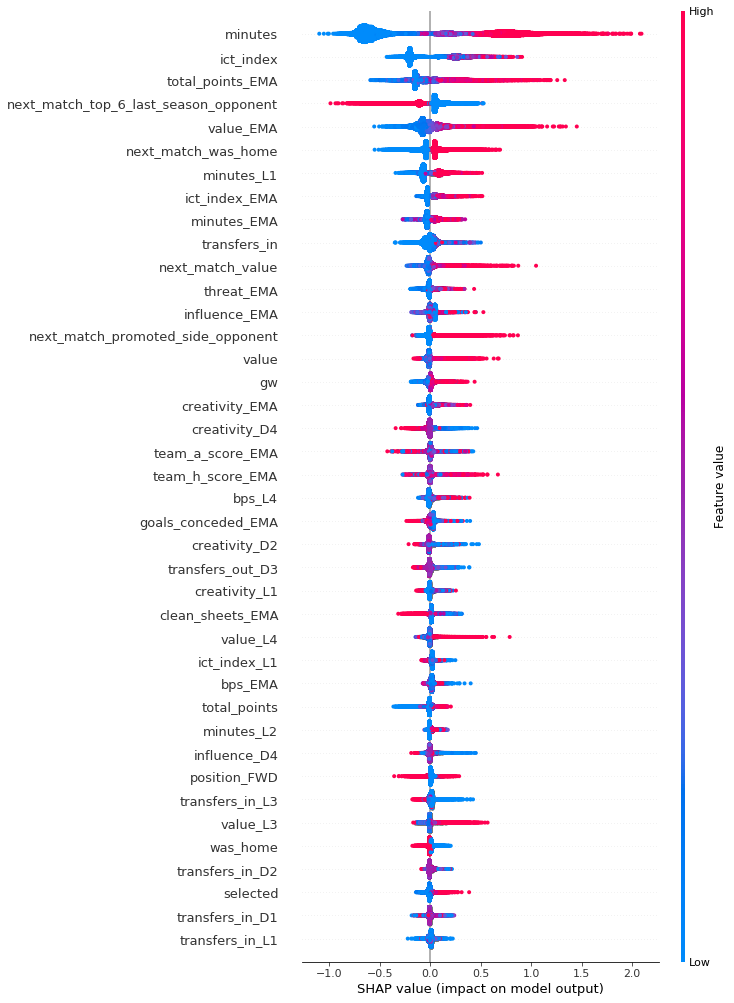

In [7]:
# LightGBM shap
shap_values = shap.TreeExplainer(new_lgbm).shap_values(
    training_data.drop(
        object_columns + ['total_points_plus_1_gw'],
        axis=1
    )
)
shap.summary_plot(
    shap_values,
    training_data.drop(
        object_columns + ['total_points_plus_1_gw'],
        axis=1
    ),
    max_display=40
)

## Evaluate on test set

In [8]:
test_data = pd.read_parquet('src/models/train_test_data/v_2_2_lgbm_test_data.parquet')
print(test_data.shape)
test_data.head()

(10805, 294)


,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,...,own_goals_EMA,own_goals_L1,own_goals_L2,own_goals_L3,own_goals_L4,own_goals_D1,own_goals_D2,own_goals_D3,own_goals_D4,total_points_plus_1_gw
0,0,0,17,0,12.6,2,0,2.9,12.0,90,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,0,8,0,2.0,2,0,1.1,9.2,90,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
2,0,0,21,1,15.4,0,0,3.5,13.2,90,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,0,13,0,15.3,2,0,4.1,21.4,90,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0.0,0,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [30]:
test_predictions = new_lgbm.predict(
    test_data.drop(
        object_columns + ['total_points_plus_1_gw'],
        axis=1
    )
)

In [10]:
mean_squared_error(test_data['total_points_plus_1_gw'], test_predictions)

4.645801749054004

In [11]:
mean_absolute_error(test_data['total_points_plus_1_gw'], test_predictions)

1.1975165451081544